In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

import jax
import jax.numpy as jnp

In [ ]:
mean1 = [0.0, 0.0]
mean2 = [2.0, 1.0]
cov1 = [[.7, .5], [.5, .7]]
cov2 = [[.1, -.05], [-.05, .1]]

data1 = np.random.multivariate_normal(mean1, cov1, size=1000)
rn_jnp1 = jax.numpy.array(data1)
data2 = np.random.multivariate_normal(mean2, cov2, size=500)
rn_jnp2 = jax.numpy.array(data2)

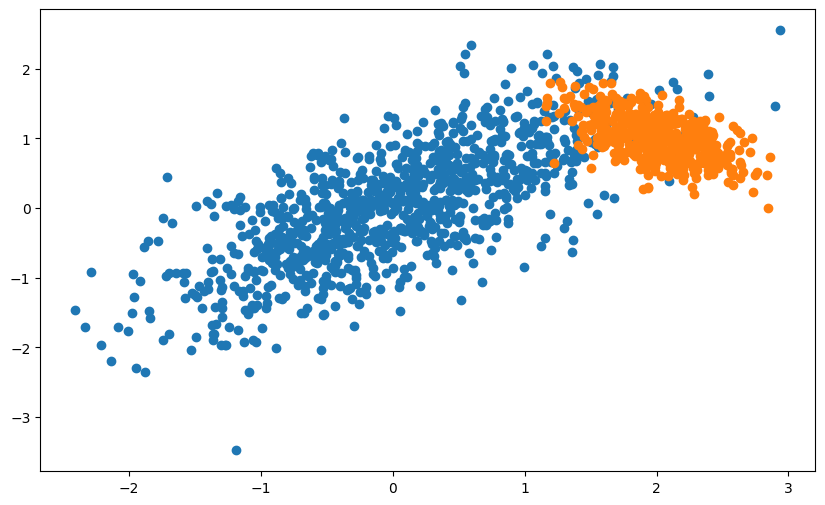

In [ ]:
def plot_scatter(data_list):
    plt.figure(figsize=(10, 6))
    for data in data_list:
        plt.scatter(data[:,0], data[:,1])
    plt.show()

plot_scatter([rn_jnp1, rn_jnp2])

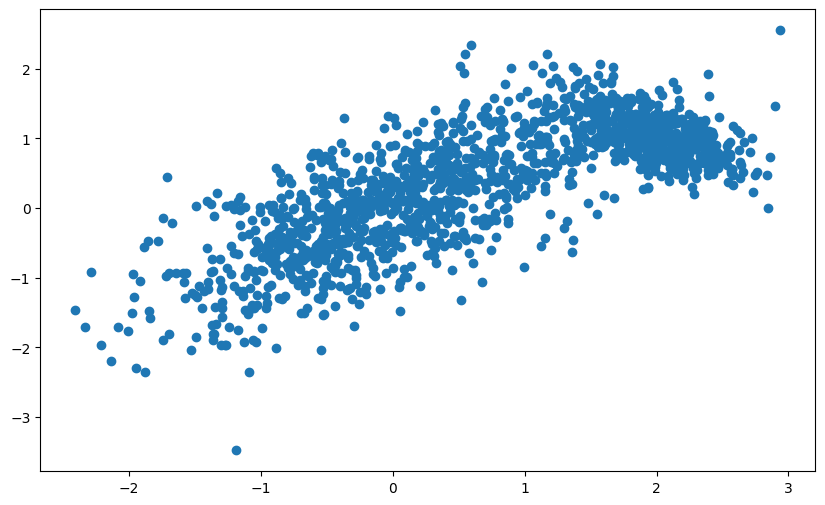

In [ ]:
X = np.vstack((rn_jnp1, rn_jnp2))
plot_scatter([X])

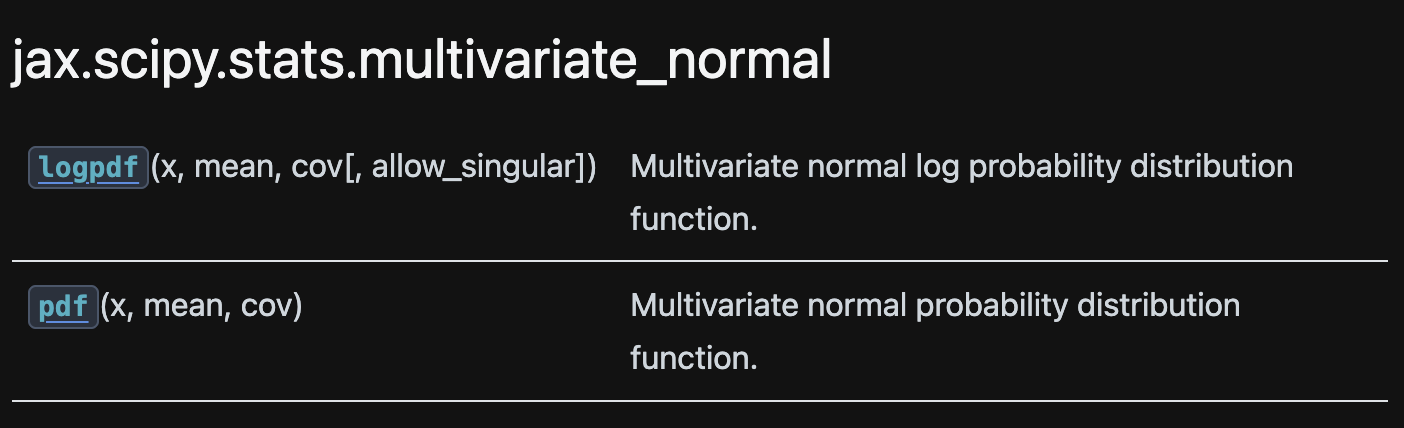

In [ ]:
from jax.scipy.stats import multivariate_normal

# Q: 라이브러리 사용하면 안되는 이유?
def compute_gaussian_pdf(x, mu, sigma):
    """
    x: d array
    mu: d array
    sigma: d x d array
    """
    return multivariate_normal.pdf(x, mean=mu, cov=sigma)

In [ ]:
@jax.jit # JAX의 jit 활용
def compute_component_pdf(x, mus, sigmas):
    """
    mus: K x d array
    sigmas: K x d x d array
    """
    def compute_gaussian_pdf(x, mu, sigma):
        """
        x: d array
        mu: d array
        sigma: d x d array
        """
        d = x.shape[0]

        # 정규화 상수 계산
        det_sigma = jnp.linalg.det(sigma)
        normalization = ((2 * jnp.pi) ** d * det_sigma) ** -0.5

        # Mahalanobis 거리 계산
        diff = x - mu
        mahalanobis = -0.5 * (diff @ jnp.linalg.solve(sigma, diff))

        # PDF 계산
        pdf = normalization * jnp.exp(mahalanobis)
        return pdf

    return jax.vmap(lambda mu, sigma: compute_gaussian_pdf(x, mu, sigma))(mus, sigmas)

In [ ]:
# import numba
# @numba.jit(parallel=True)
# def compute_component_pdf(x, mus, sigmas):
#     """
#     mus: K x d array
#     sigmas: K x d x d array
#     """
#     def compute_gaussian_pdf(x, mu, sigma):
#         """
#         x: d array
#         mu: d array
#         sigma: d x d array
#         """
#         d = len(x)
#         pdf = (((np.pi)**d) * np.linalg.det(sigma))**(-0.5) * np.exp(-0.5 * (x - mu) @ np.linalg.solve(sigma, (x - mu).T))
#         return pdf

#     num_component = len(mus)
#     return np.array([compute_gaussian_pdf(x, mus[k, :], sigmas[k, :, :]) for k in range(num_component)])

In [ ]:
@jax.jit
def compute_log_likelihood_function(X, weights, mus, sigmas):
    weights = weights.reshape(-1, 1) # (K, 1)
    compute_component_prob = lambda x: compute_component_pdf(x, mus, sigmas)
    prob_nk = jnp.apply_along_axis(arr=X, func1d=compute_component_prob, axis=1) # (N, K)
    prob_component = prob_nk * weights.T # (N, K)
    likelihood = jnp.sum(prob_component, axis=1) # (N, 1)
    return likelihood, prob_component, jnp.sum(jnp.log(likelihood))


# @jax.jit
# def compute_log_likelihood_function(X, weights, mus, sigmas):
#     weights = weights.reshape(-1, 1) # (K, 1) # 그런데 JAX는 자동으로 broadcasting 해주긴 함.

#     # 모든 데이터 포인트에 대해 병렬로 컴포넌트 확률 계산
#     prob_nk = jax.vmap(lambda x: compute_component_pdf(x, mus, sigmas))(X) # vmap 사용하면 더 빠르다고 함.

#     # 가중치 적용
#     prob_component = prob_nk * weights.T  # (N, K)

#     # 각 데이터 포인트의 전체 확률
#     likelihood = jnp.sum(prob_component, axis=1)  # (N,)

#     # 전체 로그 가능도 계산
#     log_likelihood = jnp.sum(jnp.log(likelihood))

#     return likelihood, prob_component, log_likelihood


In [ ]:
# def compute_log_likelihood_function(X, weights, mus, sigmas):
#     weights = weights.reshape(-1, 1) # (K, 1)
#     compute_component_prob = lambda x: compute_component_pdf(x, mus, sigmas)
#     prob_nk = np.apply_along_axis(arr=X, func1d=compute_component_prob, axis=1) # (N, K)
#     prob_component = prob_nk * weights.T # (N, K)
#     likelihood = np.sum(prob_component, axis=1) # (N, 1)
#     return likelihood, prob_component, np.sum(np.log(likelihood))

In [ ]:
def compute_responsibility(likelihood, prob_component):
    return prob_component / likelihood # (N, K)

In [ ]:
def compute_weights(N, N_k):
    """compute (pi_1,...,pi_K): K-dim vector"""
    return N_k / N # (1, K)

def compute_mus(X, gamma, N_k):
    """compute (mu_1,...,mu_K): (K, d) matrix"""
    return (gamma.T @ X) / N_k # (K, N) x (N, d) = (K, d)

def compute_covariance(X, gamma, mus, N_k):
    """compute (sigma_1,...,sigma_K): (K, d, d) tensor""" # jnp.newaxis 대신 None을 써도 브로드캐스팅 가능
    centered_X = (X[jnp.newaxis, :, :] - mus[:, jnp.newaxis, :])[:, :, :, jnp.newaxis] # (K, N, d, 1)
    cov_matrix = centered_X @ centered_X.transpose(0, 1, 3, 2) # (K, N, d, d)
    (gamma.T)[:, :, jnp.newaxis, jnp.newaxis] * cov_matrix # (K, N, d, d)
    return jnp.sum(cov_matrix, axis=1) / N_k # (K, d, d)

In [ ]:
# def compute_weights(N, N_k):
#     """compute (pi_1,...,pi_K): K-dim vector"""
#     return N_k / N # (1, K)

# def compute_mus(X, gamma, N_k):
#     """compute (mu_1,...,mu_K): (K, d) matrix"""
#     return (gamma.T @ X) / N_k # (K, N) x (N, d) = (K, d)

# def compute_covariance(X, gamma, mus, N_k):
#     """compute (sigma_1,...,sigma_K): (K, d, d) tensor"""
#     centered_X = (X[np.newaxis, :, :] - mus[:, np.newaxis, :])[:, :, :, np.newaxis] # (K, N, d, 1)
#     cov_matrix = centered_X @ centered_X.transpose(0, 1, 3, 2) # (K, N, d, d)
#     (gamma.T)[:, :, np.newaxis, np.newaxis] * cov_matrix # (K, N, d, d)
#     return np.sum(cov_matrix, axis=1) / N_k # (K, d, d)

In [ ]:
# class GaussianMixture():
#     def __init__(self, num_components=2):
#         self.num_components = num_components
#         self.weights = None
#         self.mus = None
#         self.sigmas = None
#         self.log_likelihood = None
#         self.gamma = None
#         self.X = None
#         self.N = None

#     def init_parameters(self):
#         self.weights = np.ones(self.num_components) / self.num_components
#         self.mus = self.X[np.random.choice(np.arange(self.N), self.num_components, replace=False)]
#         self.sigmas = np.array([np.cov(self.X.T) for _ in range(self.num_components)])

#     def compute_log_likelihood_function(self):
#         weights = self.weights.reshape(-1, 1) # (K, 1)
#         compute_component_prob = lambda x: compute_component_pdf(x, self.mus, self.sigmas)
#         prob_nk = np.apply_along_axis(arr=self.X, func1d=compute_component_prob, axis=1) # (N, K)
#         prob_component = prob_nk * weights.T # (N, K)
#         likelihood = np.sum(prob_component, axis=1, keepdims=True) # (N, 1)
#         self.log_likelihood = np.sum(np.log(likelihood)) / self.N # update log_likelihood
#         return likelihood, prob_component

#     def compute_responsibility(self, likelihood, prob_component):
#         return prob_component / likelihood # (N, K)

#     def compute_weights(self, N_k):
#         """compute (pi_1,...,pi_K): K-dim vector"""
#         return N_k / self.N # (1, K)

#     def compute_mus(self, N_k):
#         """compute (mu_1,...,mu_K): (K, d) matrix"""
#         N_k = N_k.reshape(-1, 1) # (K, 1)
#         return (self.gamma.T @ self.X) / N_k # (K, N) x (N, d) = (K, d)

#     def compute_covariance(self, N_k):
#         """compute (sigma_1,...,sigma_K): (K, d, d) tensor"""
#         N_k = N_k.reshape(-1, 1, 1) # (K, 1, 1)
#         centered_X = (self.X[np.newaxis, :, :] - self.mus[:, np.newaxis, :])[:, :, :, np.newaxis] # (K, N, d, 1)
#         cov_matrix = centered_X @ centered_X.transpose(0, 1, 3, 2) # (K, N, d, d)
#         cov_matrix = (self.gamma.T)[:, :, np.newaxis, np.newaxis] * cov_matrix # (K, N, d, d)
#         return np.sum(cov_matrix, axis=1) / N_k # (K, d, d)

#     def E_step(self):
#         # parameter initialization
#         if self.weights is None:
#             self.init_parameters()
#         likelihood, prob_component = self.compute_log_likelihood_function()
#         self.gamma = self.compute_responsibility(likelihood, prob_component)

#     def M_step(self):
#         if self.weights is None:
#             self.E_step()
#         N_k = np.sum(self.gamma, axis=0) # (K, )
#         self.weights = self.compute_weights(N_k)
#         self.mus = self.compute_mus(N_k)
#         self.sigmas = self.compute_covariance(N_k)

#     def fit(self, X, max_iter=100, tol=1e-4):
#         self.X = X
#         self.N = len(self.X)
#         self.init_parameters()
#         prev_log_likelihood = -np.inf

#         start_time = time.time()
#         # iterative update
#         for iter in range(max_iter):
#             self.E_step()

#             if self.log_likelihood - prev_log_likelihood < tol:
#                 break
#             else:
#                 prev_log_likelihood = self.log_likelihood
#                 self.M_step()

#         end_time = time.time()
#         wall_clock_time = end_time - start_time
#         print(f"EM algorithm is done at {iter}-th step. (wall-clock time: {wall_clock_time} secs)\nLog-likelihood: {self.log_likelihood}")
#         print("="*30)
#         print(f"- Estimated mixture weights:\n{self.weights}")
#         print("-"*20)
#         print(f"- Estimated mus:\n{self.mus}")
#         print("-"*20)
#         print(f"- Estimated sigmas:\n{self.sigmas}")
#         print("="*30)

#     def sampling(self, sample_size=1000):
#         index_set = [num for num in np.arange(self.num_components)]
#         index = np.random.choice(index_set, p=self.weights, size=sample_size)
#         sampled_data = [np.random.multivariate_normal(self.mus[k, :], self.sigmas[k, :, :], size=sample_size)[index==k] for k in index_set]
#         return sampled_data

JAX에서는 동일한 키 -> 동일한 난수 생성되므로,  
새로운 난수를 생성하려면 키를 분할해야 함 => `jax.random.split 함수`를 사용하면 여러 개의 새로운 키로 분할 가능

---

컴포넌트 인덱스를 샘플링한다는 것: 데이터 샘플이 어떤 mixtur e model 구성 요소(컴포넌트)에 속하는지를 결정  
self.num_components 중 self.weights(각 컴포넌트에 데이터가 속할 확률)에 따라 jax.random.choice로 sample_size 개의 컴포넌트 인덱스를 샘플링


In [102]:
class GaussianMixture():
    def __init__(self, num_components=2):
        self.num_components = num_components
        self.weights = None
        self.mus = None
        self.sigmas = None
        self.log_likelihood = None
        self.gamma = None
        self.X = None
        self.N = None

    def init_parameters(self, key):
        key1, key2 = jax.random.split(key)  # 랜덤 키를 두 개로 나눔 (키1: 평균 샘플링, 키2: 공분산 계산)
        self.weights = jnp.ones(self.num_components) / self.num_components # 초기 가중치는 모든 컴포넌트에 균등 분배

        # 데이터를 랜덤하게 선택해 초기 평균 설정
        indices = jax.random.choice(key1, jnp.arange(self.N), shape = (self.num_components, ), replace=False)

        self.mus = self.X[indices]  # 평균 초기화

        # 모든 컴포넌트의 공분산 행렬을 동일하게 초기화
        self.sigmas = jnp.array([jnp.cov(self.X.T) for _ in range(self.num_components)]) # Q. jnp.stack을 사용하지 않은 이유?

    def compute_log_likelihood_function(self):
        weights = self.weights.reshape(-1, 1) # (K, 1)
        compute_component_prob = lambda x: compute_component_pdf(x, self.mus, self.sigmas)
        prob_nk = jnp.apply_along_axis(arr=X, func1d=compute_component_prob, axis=1) # (N, K)
        prob_component = prob_nk * weights.T # (N, K)
        likelihood = jnp.sum(prob_component, axis=1, keepdims=True) # (N, 1)
        self.log_likelihood = jnp.sum(np.log(likelihood)) / self.N # update log_likelihood
        return likelihood, prob_component

    def compute_responsibility(self, likelihood, prob_component):
        return prob_component / likelihood # (N, K)

    def compute_weights(self, N_k):
        """compute (pi_1,...,pi_K): K-dim vector"""
        return N_k / self.N # (1, K)

    def compute_mus(self, N_k):
        """compute (mu_1,...,mu_K): (K, d) matrix"""
        N_k = N_k.reshape(-1, 1) # (K, 1)
        return (self.gamma.T @ self.X) / N_k # (K, N) x (N, d) = (K, d)

    def compute_covariance(self, N_k):
        """compute (sigma_1,...,sigma_K): (K, d, d) tensor"""
        N_k = N_k.reshape(-1, 1, 1) # (K, 1, 1)
        centered_X = (self.X[jnp.newaxis, :, :] - self.mus[:, jnp.newaxis, :])[:, :, :, jnp.newaxis] # (K, N, d, 1)
        cov_matrix = centered_X @ centered_X.transpose(0, 1, 3, 2) # (K, N, d, d)
        cov_matrix = (self.gamma.T)[:, :, jnp.newaxis, jnp.newaxis] * cov_matrix # (K, N, d, d)
        return jnp.sum(cov_matrix, axis=1) / N_k # (K, d, d)

    def E_step(self):
        # parameter initialization
        if self.weights is None:
            self.init_parameters()
        likelihood, prob_component = self.compute_log_likelihood_function()
        self.gamma = self.compute_responsibility(likelihood, prob_component)

    def M_step(self):
        if self.weights is None:
            self.E_step()
        N_k = jnp.sum(self.gamma, axis=0) # (K, )
        self.weights = self.compute_weights(N_k)
        self.mus = self.compute_mus(N_k)
        self.sigmas = self.compute_covariance(N_k)

    def fit(self, X, max_iter=100, tol=1e-4, seed = 0):
        self.X = X
        self.N = len(self.X)
        key = jax.random.PRNGKey(seed) # PRNG 키 생성
        self.init_parameters(key)

        prev_log_likelihood = -jnp.inf

        start_time = time.time()
        # iterative update
        for iter in range(max_iter):
            self.E_step()

            if self.log_likelihood - prev_log_likelihood < tol:
                break
            else:
                prev_log_likelihood = self.log_likelihood
                self.M_step()

        end_time = time.time()
        wall_clock_time = end_time - start_time
        print(f"EM algorithm is done at {iter}-th step. (wall-clock time: {wall_clock_time} secs)\nLog-likelihood: {self.log_likelihood}")
        print("="*30)
        print(f"- Estimated mixture weights:\n{self.weights}")
        print("-"*20)
        print(f"- Estimated mus:\n{self.mus}")
        print("-"*20)
        print(f"- Estimated sigmas:\n{self.sigmas}")
        print("="*30)

    def sampling(self, sample_size=1000, key=None):
        key1, key2 = jax.random.split(key) # key1: 컴포넌트 인덱스 샘플링에 사용
        indices = jax.random.choice(key1, jnp.arange(self.num_components), shape = (sample_size, ), p = self.weights) # key1을 사용하여 self.weights에 따라 컴포넌트 인덱스를 샘플링함

        # 각 샘플을 생성
        def sample_single(index, subkey):
            return jax.random.multivariate_normal(subkey, self.mus[index], self.sigmas[index])

        # key2를 sample_size만큼 분할하여, 샘플 개수에 맞는 독립된 난수 키를 생성
        subkeys = jax.random.split(key2, sample_size) # 각 subkey는 하나의 샘플 생성을 담당하며, 다른 샘플과 독립된 난수를 생성
        sampled_data = jax.vmap(sample_single)(indices, subkeys)  # 벡터화로 각 샘플 생성

        component_data = [sampled_data[indices == k] for k in range(self.num_components)]

        return component_data

In [103]:
gmm = GaussianMixture(num_components=2)

In [104]:
key = jax.random.PRNGKey(0)  # PRNG 키 생성
gmm.fit(X, max_iter=100, seed=0)  # 키를 전달
data = gmm.sampling(sample_size=1000, key=key)  # 키를 전달해 샘플링

EM algorithm is done at 21-th step. (wall-clock time: 0.0786130428314209 secs)
Log-likelihood: -2.5633437633514404
- Estimated mixture weights:
[0.46343818 0.5365619 ]
--------------------
- Estimated mus:
[[-0.09593665 -0.09242299]
 [ 2.4083934   0.7915794 ]]
--------------------
- Estimated sigmas:
[[[ 0.6751396   0.4518132 ]
  [ 0.4518132   0.6268597 ]]

 [[ 0.58223623 -0.08208546]
  [-0.08208546  0.2868669 ]]]


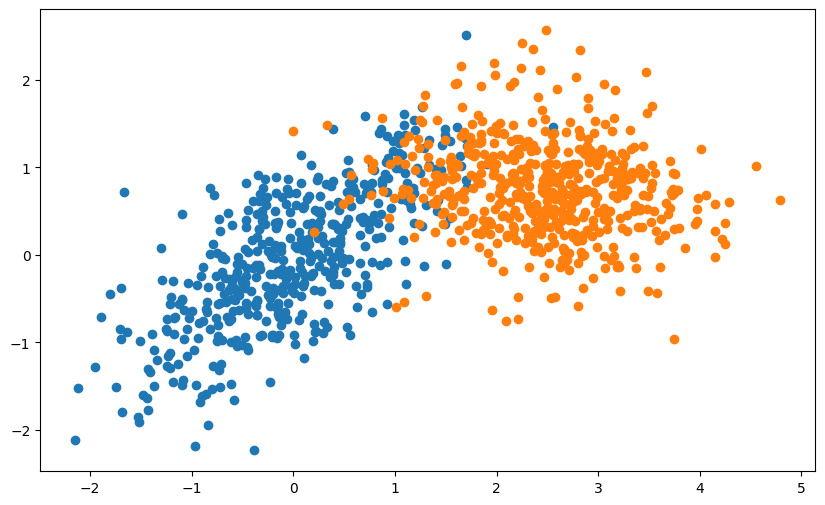

In [105]:
plot_scatter(data)

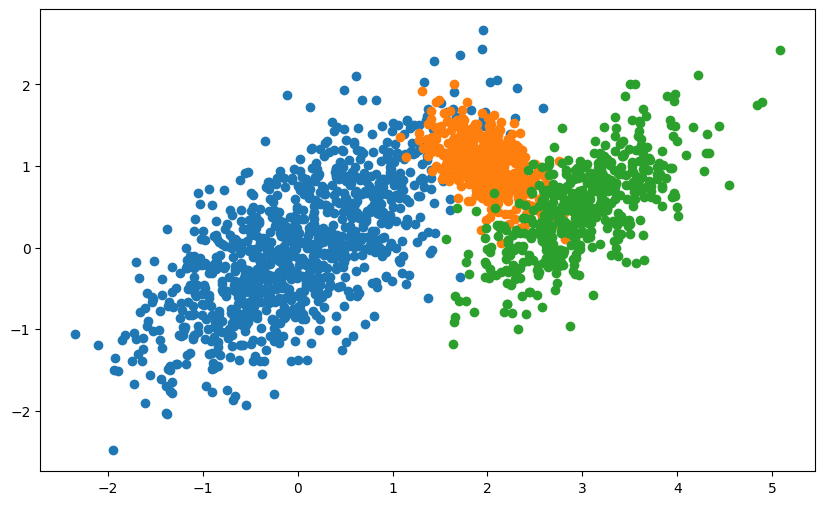

In [106]:
mean1 = [0.0, 0.0]
mean2 = [2.0, 1.0]
mean3 = [3.0, 0.5]
cov1 = [[.7, .5], [.5, .7]]
cov2 = [[.1, -.05], [-.05, .1]]
cov3 = [[.3, .2], [.2, .3]]

data1 = np.random.multivariate_normal(mean1, cov1, size=1000)
data2 = np.random.multivariate_normal(mean2, cov2, size=500)
data3 = np.random.multivariate_normal(mean3, cov3, size=500)
plot_scatter([data1, data2, data3])

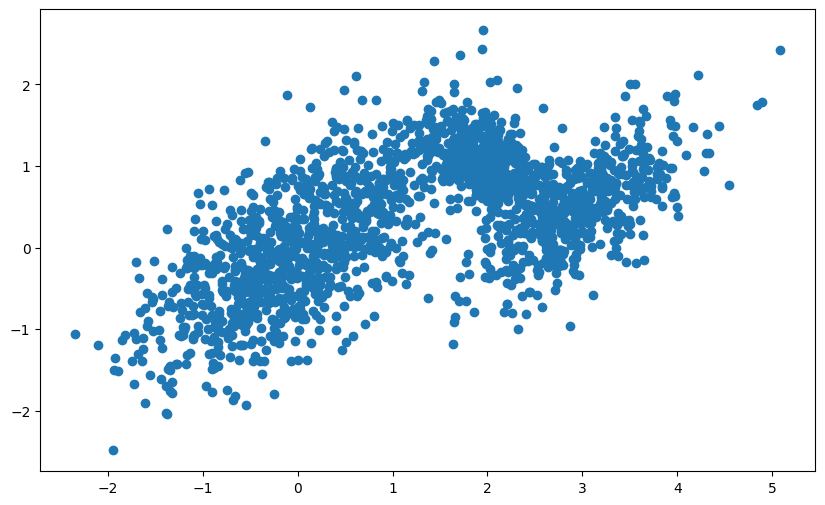

In [107]:
X = np.vstack((data1, data2, data3))
plot_scatter([X])

In [108]:
gmm = GaussianMixture(num_components=3)

In [110]:
gmm.fit(X, max_iter=200)
sampled_data = gmm.sampling(sample_size=2000, key=key)

EM algorithm is done at 37-th step. (wall-clock time: 0.12499284744262695 secs)
Log-likelihood: -2.3822221755981445
- Estimated mixture weights:
[0.49182948 0.24980842 0.2583621 ]
--------------------
- Estimated mus:
[[-0.00480527 -0.01706055]
 [ 2.984275    0.47103363]
 [ 1.9898099   1.0096614 ]]
--------------------
- Estimated sigmas:
[[[ 0.64342743  0.43344077]
  [ 0.43344077  0.6191165 ]]

 [[ 0.31942344  0.218927  ]
  [ 0.218927    0.31078616]]

 [[ 0.11157477 -0.05557564]
  [-0.05557564  0.09848093]]]


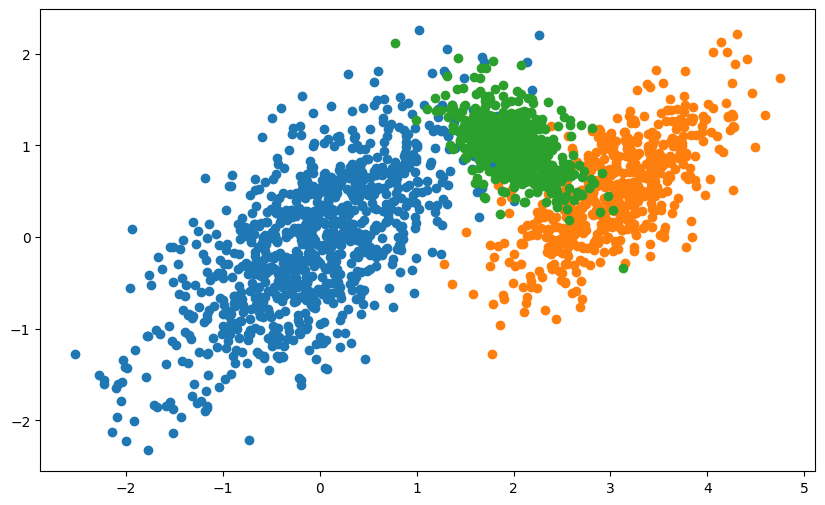

In [111]:
plot_scatter(sampled_data)

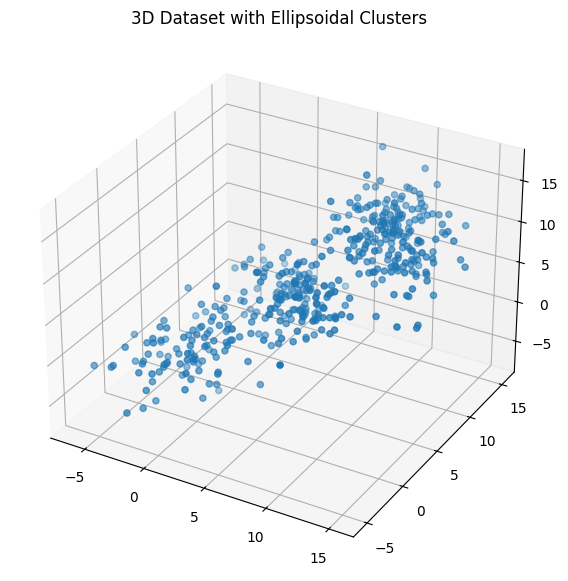

In [112]:
means = np.array([[0, 0, 0], [5, 5, 5], [10, 10, 10]])
covs = [np.eye(3), np.eye(3) * 2, np.eye(3) / 2]  # Different covariances for variety
sizes = [100, 150, 200]  # Different sizes for the clusters
covs_very_spreaded = [
    np.array([[5, 2, 1], [2, 5, 2], [1, 2, 5]]),
    np.array([[5, -2, 1], [-2, 5, -1], [1, -1, 5]]),
    np.array([[5, 0, -2], [0, 5, 2], [-2, 2, 5]])
]

real_data = np.vstack([np.random.multivariate_normal(mean, cov, size) for mean, cov, size in zip(means, covs_very_spreaded, sizes)])

# Plotting the generated very spreaded ellipsoidal clusters
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(real_data[:, 0], real_data[:, 1], real_data[:, 2])
ax.set_title('3D Dataset with Ellipsoidal Clusters')
plt.show()

In [116]:
gmm_3d = GaussianMixture(num_components=3)
gmm_3d.fit(real_data, max_iter=200)
sampled_data_3d = gmm_3d.sampling(sample_size=2000, key = key)

TypeError: sub got incompatible shapes for broadcasting: (2,), (3,).

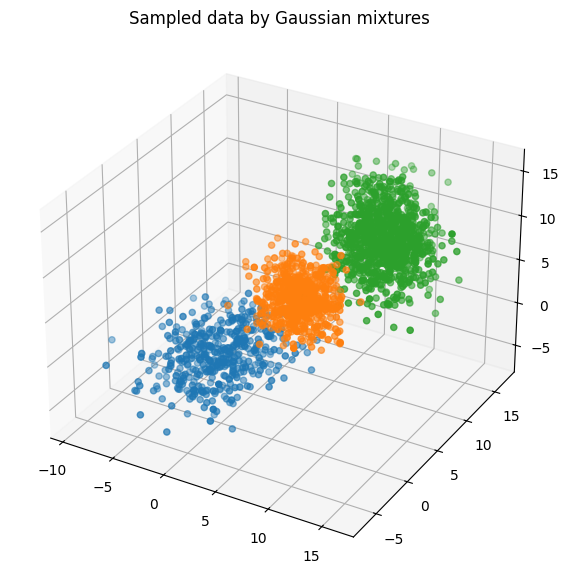

In [ ]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
for i in range(3):
    ax.scatter(sampled_data_3d[i][:, 0], sampled_data_3d[i][:, 1], sampled_data_3d[i][:, 2])
ax.set_title('Sampled data by Gaussian mixtures')
plt.show()

In [ ]:
import pandas as pd

# https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data
!kaggle datasets download -d parulpandey/palmer-archipelago-antarctica-penguin-data
!unzip palmer-archipelago-antarctica-penguin-data

# load the dataset
df = pd.read_csv('penguins_size.csv')

# remove null values
df = df[~df.isnull().any(axis=1)]
df = df.reset_index(drop=True)
features = ['culmen_length_mm', 'culmen_depth_mm']
data = df[features]
data_ndarray = np.array(data)

Dataset URL: https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data
License(s): CC0-1.0
  0% 0.00/11.3k [00:00<?, ?B/s]
100% 11.3k/11.3k [00:00<00:00, 17.8MB/s]
Archive:  palmer-archipelago-antarctica-penguin-data.zip
  inflating: penguins_lter.csv       
  inflating: penguins_size.csv       


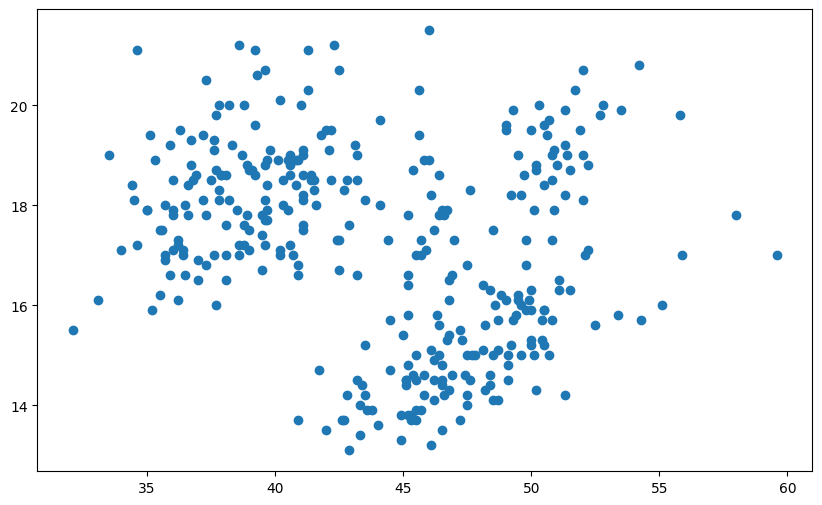

In [ ]:
plot_scatter([data_ndarray])

EM algorithm is done at 30-th step. (wall-clock time: 1.1666042804718018 secs)
Log-likelihood: -4.8046948095995505
- Estimated mixture weights:
[0.3043013  0.26192346 0.43377525]
--------------------
- Estimated mus:
[[47.165314 14.786765]
 [48.96725  18.049028]
 [38.76702  18.289145]]
--------------------
- Estimated sigmas:
[[[ 7.4497905   1.5376177 ]
  [ 1.5376177   0.71463203]]

 [[12.183901    1.3853017 ]
  [ 1.3853017   2.0550168 ]]

 [[ 6.6391788   0.9499767 ]
  [ 0.9499767   1.4555342 ]]]


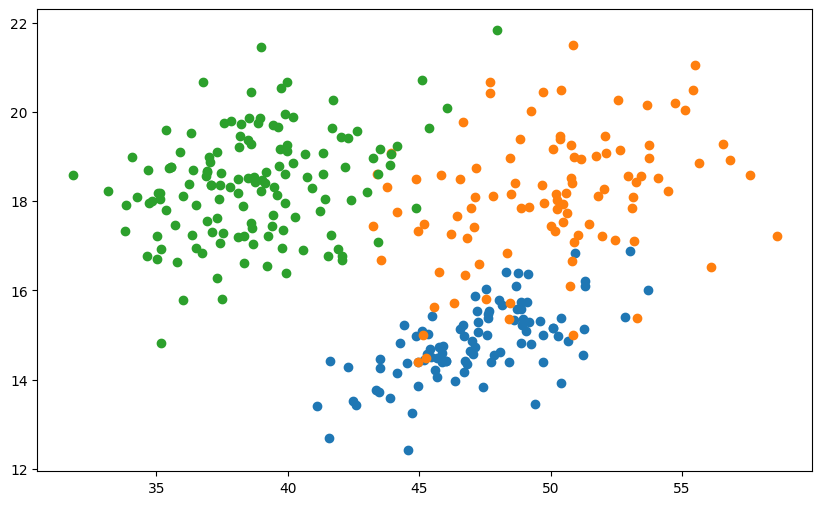

In [ ]:
gmm_penguin = GaussianMixture(num_components=3)
gmm_penguin.fit(data_ndarray, max_iter=200)
sampled_data_penguin = gmm_penguin.sampling(sample_size=len(data_ndarray))
plot_scatter(sampled_data_penguin)